In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


In [ ]:
import os
import shutil
import random

# Define paths
original_data_path = '/content/drive/My Drive'
output_data_path = '/content/drive/My Drive/Skin Detection Using CNN, DL'

# Define ratios for splitting
train_ratio = 0.8

test_ratio = 0.2

# Create directories for train, validation, and test sets
train_path = os.path.join(output_data_path, 'train')

test_path = os.path.join(output_data_path, 'test')

os.makedirs(train_path, exist_ok=True)

os.makedirs(test_path, exist_ok=True)

# List classes
classes = ['Oily', 'Dry', 'Normal']

# Iterate through classes
for class_name in classes:
    # Get list of files in current class
    class_files = os.listdir(os.path.join(original_data_path, 'Skin Detection Using CNN, DL', class_name))
    # Shuffle files
    random.shuffle(class_files)

    # Split files into train, val, and test sets
    num_files = len(class_files)
    num_train = int(num_files * train_ratio)
    num_test = int(num_files * test_ratio)


    # Copy files to respective directories
    for i, file_name in enumerate(class_files):
        src = os.path.join(original_data_path, 'Skin Detection Using CNN, DL', class_name, file_name)
        if i < num_train:
            dst = os.path.join(train_path, class_name, file_name)

        else:
            dst = os.path.join(test_path, class_name, file_name)

        # Create directories if they don't exist
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        # Copy file
        shutil.copy(src, dst)

print("Data splitting and copying completed successfully.")

Data splitting and copying completed successfully.


In [ ]:
import os
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

def augment_images(class_directory, output_directory):
    # Create the output directory if it doesn't exist
    os.makedirs(output_directory, exist_ok=True)

    # Define augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=20,      # Randomly rotate images by up to 20 degrees
        width_shift_range=0.1,  # Randomly shift images horizontally by up to 10% of the width
        height_shift_range=0.1, # Randomly shift images vertically by up to 10% of the height
        horizontal_flip=True,   # Randomly flip images horizontally
        zoom_range=0.1
    )

    # List all images in the class directory
    image_files = [file for file in os.listdir(class_directory) if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Augment each image and save the augmented images
    for image_file in image_files:
        image_path = os.path.join(class_directory, image_file)
        img = image.load_img(image_path, target_size=(224, 224))
        x = image.img_to_array(img)
        x = x.reshape((1,) + x.shape)  # Reshape to (1, height, width, channels)

        # Generate augmented images and save them directly into the output directory
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=output_directory, save_prefix='augmented_' + image_file.split('.')[0], save_format='jpg'):
            i += 1
            if i >= 4:  # Generate 4 augmented images per original image
                break

# Define paths for Dry class
train_path_dry = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry'
output_augmented_path_dry = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry'

# Define paths for Oily class
train_path_oily = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily'
output_augmented_path_oily = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily'

# Define paths for Normal class
train_path_normal = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal'
output_augmented_path_normal = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal'

# Function to augment images for Dry class
augment_images(train_path_dry, output_augmented_path_dry)

# Function to augment images for Oily class
augment_images(train_path_oily, output_augmented_path_oily)

# Function to augment images for Normal class
augment_images(train_path_normal, output_augmented_path_normal)

In [ ]:
import os

# Define the parent directory containing the three class directories
parent_directory = '/content/drive/My Drive/Skin Detection Using CNN, DL/train'

# List of class names
class_names = ['Dry', 'Normal', 'Oily']

# Dictionary to store the counts for each class
class_counts = {}

# Iterate over each class directory
for class_name in class_names:
    # Define the path to the class directory
    class_path = os.path.join(parent_directory, class_name)

    # List all files in the class directory
    files_in_directory = os.listdir(class_path)

    # Count the number of images in the class directory
    num_images = len(files_in_directory)

    # Store the count in the dictionary
    class_counts[class_name] = num_images

# Print the counts for each class
for class_name, count in class_counts.items():
    print("Number of images in '{}' class: {}".format(class_name, count))

Number of images in 'Dry' class: 400
Number of images in 'Normal' class: 390
Number of images in 'Oily' class: 420


In [ ]:
import os
import cv2
import numpy as np
from skimage import exposure

# Define paths
augmented_data_path = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/'

# Load face detection cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

# Function to perform preprocessing including resize, HSV color space conversion, histogram equalization, and pixel normalization
def preprocess_image(image):
    # Resize the image to a desired size
    resized_image = cv2.resize(image, (256, 256))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Iterate over each augmented data folder
for folder_name in os.listdir(augmented_data_path):
    folder_path = os.path.join(augmented_data_path, folder_name)

    # Create a directory to save preprocessed images
    output_folder_path = os.path.join(folder_path, 'preprocessed')
    os.makedirs(output_folder_path, exist_ok=True)

    # Iterate over each image in the folder
    for filename in os.listdir(folder_path):
        if filename.startswith('augmented'):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)

            # Detect faces
            faces = detect_faces(img)

            # Perform preprocessing
            preprocessed_img = preprocess_image(img)

            # Save the preprocessed image
            output_image_path = os.path.join(output_folder_path, filename)
            cv2.imwrite(output_image_path, preprocessed_img * 255.0)  # Convert back to 0-255 range before saving


In [ ]:
import os
import cv2
import numpy as np
from skimage import exposure

# Define paths
test_data_path = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/'

# Load face detection cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

# Function to perform preprocessing including resize, HSV color space conversion, histogram equalization, and pixel normalization
def preprocess_image(image):
    # Resize the image to a desired size
    resized_image = cv2.resize(image, (256, 256))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Iterate over each data folder (Oily, Dry, Normal)
for folder_name in os.listdir(test_data_path):
    folder_path = os.path.join(test_data_path, folder_name)

    # Skip files, process only directories
    if not os.path.isdir(folder_path):
        continue

    # Create a directory to save preprocessed images
    output_folder_path = os.path.join(folder_path, 'newpreprocessed')
    os.makedirs(output_folder_path, exist_ok=True)

    # Iterate over each image in the folder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        # Read the image
        img = cv2.imread(image_path)

        # Check if image is empty
        if img is None:
            print(f"Unable to read image: {image_path}")
            continue

        # Detect faces
        faces = detect_faces(img)

        # Perform preprocessing
        preprocessed_img = preprocess_image(img)

        # Save the preprocessed image
        output_image_path = os.path.join(output_folder_path, filename)
        cv2.imwrite(output_image_path, preprocessed_img * 255.0)  # Convert back to 0-255 range before saving


Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/newpreprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/newpreprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/newpreprocessed


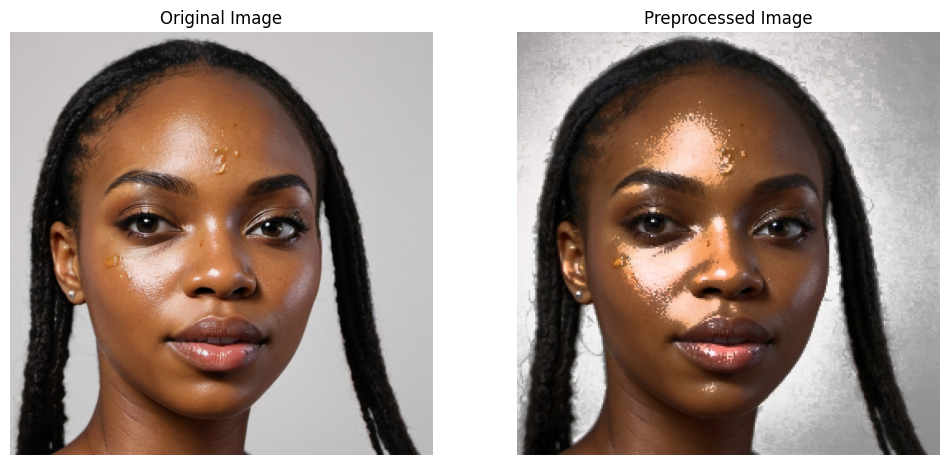

In [ ]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt

# Load an example image
example_image_path = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/Oily (106).jpg'
example_image = cv2.imread(example_image_path)

# Define preprocessing functions
def preprocess_image(image):
    # Resize the image to a desired size (e.g., 256x256)
    resized_image = cv2.resize(image, (256, 256))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Apply preprocessing
preprocessed_example_image = preprocess_image(example_image)

# Display the original and preprocessed images side by side
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Preprocessed Image')
plt.imshow(cv2.cvtColor((preprocessed_example_image * 255).astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()


In [ ]:
import os
import cv2
import numpy as np
from skimage import exposure

# Define paths
test_data_path = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/'

# Load face detection cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Function to detect faces in an image
def detect_faces(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    return faces

# Function to perform preprocessing including resize, HSV color space conversion, histogram equalization, and pixel normalization
def preprocess_image(image):
    # Resize the image to a desired size
    resized_image = cv2.resize(image, (256, 256))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Iterate over each data folder (Oily, Dry, Normal)
for folder_name in os.listdir(test_data_path):
    folder_path = os.path.join(test_data_path, folder_name)

    # Skip files, process only directories
    if not os.path.isdir(folder_path):
        continue

    # Create a directory to save preprocessed images
    output_folder_path = os.path.join(folder_path, 'preprocessed')
    os.makedirs(output_folder_path, exist_ok=True)

    # Iterate over each image in the folder
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        # Read the image
        img = cv2.imread(image_path)

        # Check if image is empty
        if img is None:
            print(f"Unable to read image: {image_path}")
            continue

        # Detect faces
        faces = detect_faces(img)

        # Perform preprocessing
        preprocessed_img = preprocess_image(img)

        # Save the preprocessed image
        output_image_path = os.path.join(output_folder_path, filename)
        cv2.imwrite(output_image_path, preprocessed_img * 255.0)  # Convert back to 0-255 range before saving


Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/DRY (9).heic
Unable to read image: /content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed


In [ ]:
import os

# Define the parent directory containing the three class directories
parent_directory = '/content/drive/My Drive/Skin Detection Using CNN, DL/train'

# List of class names
class_names = ['Dry', 'Normal', 'Oily']

# Dictionary to store the counts for each class
class_counts = {}

# Iterate over each class directory
for class_name in class_names:
    # Define the path to the preprocessed class directory
    preprocessed_class_path = os.path.join(parent_directory, class_name, 'newpreprocessed')

    # List all files in the preprocessed class directory
    files_in_directory = os.listdir(preprocessed_class_path)

    # Count the number of preprocessed images in the class directory
    num_images = len(files_in_directory)

    # Store the count in the dictionary
    class_counts[class_name] = num_images

# Print the counts for each class
for class_name, count in class_counts.items():
    print("Number of preprocessed images in '{}' class: {}".format(class_name, count))


Number of preprocessed images in 'Dry' class: 400
Number of preprocessed images in 'Normal' class: 390
Number of preprocessed images in 'Oily' class: 420


***Model Building***

**Model V1.0 - VGG16**

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import VGG16
from keras import models, layers
from keras.utils import to_categorical

In [ ]:
# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed images and labels from each class
dry_images, dry_labels = load_processed_images(dry_processed_dir, 0)  # Assign label 0 to Dry
oily_images, oily_labels = load_processed_images(oily_processed_dir, 2)  # Assign label 2 to Oily
normal_images, normal_labels = load_processed_images(normal_processed_dir, 1)  # Assign label 1 to Normal

# Combine images and labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((dry_labels, oily_labels, normal_labels), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a model using VGG16 as base
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X, y_one_hot, epochs=15, batch_size=32, validation_split=0.2)

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/vgg16_cnn_modelV1.0.h5')

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/15
25/25 [==============================] - 594s 24s/step - loss: 186.0647 - accuracy: 0.3837 - val_loss: 1.1109 - val_accuracy: 0.3608
Epoch 2/15
25/25 [==============================] - 595s 24s/step - loss: 1.2226 - accuracy: 0.4031 - val_loss: 1.0528 - val_accuracy: 0.3969
Epoch 3/15
25/25 [==============================] - 597s 24s/step - loss: 1.0880 - accuracy: 0.3953 - val_loss: 1.0168 - val_accuracy: 0.3814
Epoch 4/15
25/25 [==============================] - 586s 24s/step - loss: 1.0039 - accuracy: 0.4522 - val_loss: 1.0730 - val_accuracy: 0.3247
Epoch 5/15
25/25 [==============================] - 586s 24s/step - loss: 0.9381 - accuracy: 0.4819 - val_loss: 0.9244 - val_accuracy: 0.5206
Epoch 6/15
25/25 [==============================] - 591s 24s/step - loss: 1.0243 - accuracy: 0.4470 - val_loss: 0.9717 - val_accuracy: 0.4433
Epoch 7/15
25/25 [==============================] - 592s 24s/step - loss: 0.9154 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


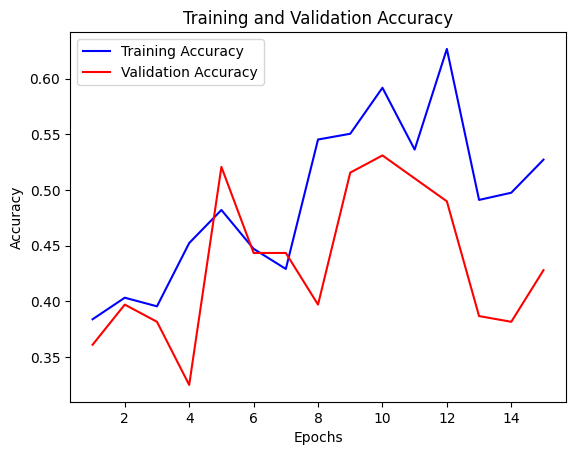

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

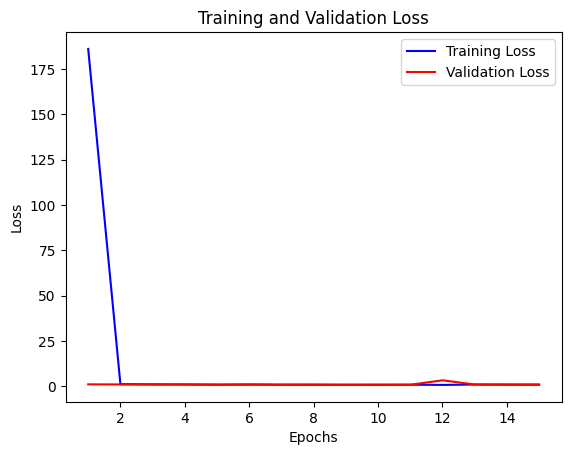

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Define the path to the testing dataset
testing_data_path = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/'

# Load the trained model
model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/vgg16_cnn_modelV1.0.h5')

# Define labels for the testing dataset
test_labels = []

# Define a function to load and preprocess testing images
def load_and_preprocess_images(folder_path, label):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))  # Resize the image to a fixed size
            # Perform preprocessing here if needed
            images.append(img)
            test_labels.append(label)  # Assign label based on the subfolder
    return np.array(images)

# Load and preprocess testing images from each class
class_folders = ['Dry', 'Normal', 'Oily']
class_labels = [0, 1, 2]  # Corresponding labels for each class

test_images = []
for folder, label in zip(class_folders, class_labels):
    class_images = load_and_preprocess_images(os.path.join(testing_data_path, folder, 'preprocessed'), label)
    test_images.append(class_images)

# Concatenate images from all classes
test_images = np.concatenate(test_images, axis=0)

# Perform predictions
predicted_labels = np.argmax(model.predict(test_images), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted', zero_division='warn')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print evaluation metrics
print(f'Testing Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')


2/2 [==============================] - 24s 11s/step
Testing Accuracy: 0.32786885245901637
Precision: 0.21846044191019243
Recall: 0.32786885245901637
F1-Score: 0.25746600584572377


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Model V2.0- EffientNet**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers

In [ ]:

# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed images and labels from each class
dry_images, dry_labels = load_processed_images(dry_processed_dir, 0)  # Assign label 0 to Dry
oily_images, oily_labels = load_processed_images(oily_processed_dir, 2)  # Assign label 2 to Oily
normal_images, normal_labels = load_processed_images(normal_processed_dir, 1)  # Assign label 1 to Normal

# Combine images and labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((dry_labels, oily_labels, normal_labels), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a model using EfficientNetB0 as base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X, y_one_hot, epochs=15, batch_size=32, validation_split=0.2)

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_0.h5')


16705208/16705208 [==============================] - 1s 0us/step
Epoch 1/15
25/25 [==============================] - 86s 3s/step - loss: 1.0945 - accuracy: 0.4251 - val_loss: 0.9087 - val_accuracy: 0.6289
Epoch 2/15
25/25 [==============================] - 72s 3s/step - loss: 0.8841 - accuracy: 0.5943 - val_loss: 0.7588 - val_accuracy: 0.7062
Epoch 3/15
25/25 [==============================] - 79s 3s/step - loss: 0.7658 - accuracy: 0.6550 - val_loss: 0.6347 - val_accuracy: 0.7474
Epoch 4/15
25/25 [==============================] - 80s 3s/step - loss: 0.6511 - accuracy: 0.7313 - val_loss: 0.5177 - val_accuracy: 0.8247
Epoch 5/15
25/25 [==============================] - 81s 3s/step - loss: 0.5924 - accuracy: 0.7416 - val_loss: 0.5147 - val_accuracy: 0.8041
Epoch 6/15
25/25 [==============================] - 72s 3s/step - loss: 0.5117 - accuracy: 0.8023 - val_loss: 0.4334 - val_accuracy: 0.8351
Epoch 7/15
25/25 [==============================] - 78s 3s/step - loss: 0.4422 - accuracy: 0.82

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to the preprocessed testing image directories
dry_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed'
normal_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed'
oily_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed'

# Function to load processed images and labels from a directory
def load_processed_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed testing images and labels for each class
dry_test_images, dry_test_labels = load_processed_images_and_labels(dry_test_dir, 0)
normal_test_images, normal_test_labels = load_processed_images_and_labels(normal_test_dir, 1)
oily_test_images, oily_test_labels = load_processed_images_and_labels(oily_test_dir, 2)

# Concatenate testing images and labels
X_test = np.concatenate((dry_test_images, normal_test_images, oily_test_images), axis=0)
y_test = np.concatenate((dry_test_labels, normal_test_labels, oily_test_labels), axis=0)

# One-hot encode the target labels
y_test_one_hot = to_categorical(y_test)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_0.h5')

# Evaluate the loaded model on the testing set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_one_hot, verbose=1)

# Predict labels for the testing set using the loaded model
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score using scikit-learn metrics functions
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


2/2 [==============================] - 16s 4s/step
Testing Accuracy: 0.6779661178588867
Precision: 0.6962239366342845
Recall: 0.6779661016949152
F1 Score: 0.6690792487402657


**Model V2.1 EffientNet**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed images and labels from each class
dry_images, dry_labels = load_processed_images(dry_processed_dir, 0)  # Assign label 0 to Dry
oily_images, oily_labels = load_processed_images(oily_processed_dir, 2)  # Assign label 2 to Oily
normal_images, normal_labels = load_processed_images(normal_processed_dir, 1)  # Assign label 1 to Normal

# Combine images and labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((dry_labels, oily_labels, normal_labels), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a model using EfficientNetB0 as base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y_one_hot, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Fine-tune the model by unfreezing the base model's layers
base_model.trainable = True

# Compile the model again for fine-tuning
model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for a few more epochs for fine-tuning
fine_tune_history = model.fit(X, y_one_hot, epochs=10, batch_size=32, validation_split=0.2)

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_1.h5')


Epoch 1/15
25/25 [==============================] - 115s 4s/step - loss: 1.0812 - accuracy: 0.4470 - val_loss: 0.8804 - val_accuracy: 0.6753
Epoch 2/15
25/25 [==============================] - 97s 4s/step - loss: 0.8770 - accuracy: 0.6034 - val_loss: 0.7202 - val_accuracy: 0.6907
Epoch 3/15
25/25 [==============================] - 80s 3s/step - loss: 0.7741 - accuracy: 0.6473 - val_loss: 0.6482 - val_accuracy: 0.7165
Epoch 4/15
25/25 [==============================] - 80s 3s/step - loss: 0.6573 - accuracy: 0.7287 - val_loss: 0.5514 - val_accuracy: 0.7938
Epoch 5/15
25/25 [==============================] - 80s 3s/step - loss: 0.5792 - accuracy: 0.7597 - val_loss: 0.4840 - val_accuracy: 0.8454
Epoch 6/15
25/25 [==============================] - 85s 3s/step - loss: 0.5276 - accuracy: 0.7726 - val_loss: 0.4247 - val_accuracy: 0.8557
Epoch 7/15
25/25 [==============================] - 80s 3s/step - loss: 0.4723 - accuracy: 0.8049 - val_loss: 0.3879 - val_accuracy: 0.8866
Epoch 8/15
25/25 [=

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to the preprocessed testing image directories
dry_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed'
normal_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed'
oily_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed'

# Function to load processed images and labels from a directory
def load_processed_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed testing images and labels for each class
dry_test_images, dry_test_labels = load_processed_images_and_labels(dry_test_dir, 0)
normal_test_images, normal_test_labels = load_processed_images_and_labels(normal_test_dir, 1)
oily_test_images, oily_test_labels = load_processed_images_and_labels(oily_test_dir, 2)

# Concatenate testing images and labels
X_test = np.concatenate((dry_test_images, normal_test_images, oily_test_images), axis=0)
y_test = np.concatenate((dry_test_labels, normal_test_labels, oily_test_labels), axis=0)

# One-hot encode the target labels
y_test_one_hot = to_categorical(y_test)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_1.h5')

# Evaluate the loaded model on the testing set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_one_hot, verbose=1)

# Predict labels for the testing set using the loaded model
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score using scikit-learn metrics functions
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2/2 [==============================] - 5s 1s/step
Testing Accuracy: 0.5762711763381958
Precision: 0.577542372881356
Recall: 0.576271186440678
F1 Score: 0.5666474723172439


**Model V2.2 effientNet**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed images and labels from each class
dry_images, dry_labels = load_processed_images(dry_processed_dir, 0)  # Assign label 0 to Dry
oily_images, oily_labels = load_processed_images(oily_processed_dir, 2)  # Assign label 2 to Oily
normal_images, normal_labels = load_processed_images(normal_processed_dir, 1)  # Assign label 1 to Normal

# Combine images and labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((dry_labels, oily_labels, normal_labels), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a model using EfficientNetB0 as base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(3, activation='softmax')
])

# Compile the model with RMSprop optimizer and categorical crossentropy loss
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),  # Using RMSprop optimizer with a lower learning rate
              loss='categorical_crossentropy',  # Categorical crossentropy loss
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y_one_hot, epochs=8, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_2.h5')


Epoch 1/8
13/13 [==============================] - 98s 7s/step - loss: 1.0190 - accuracy: 0.5401 - val_loss: 0.9987 - val_accuracy: 0.5412
Epoch 2/8
13/13 [==============================] - 89s 7s/step - loss: 0.6499 - accuracy: 0.7196 - val_loss: 0.5526 - val_accuracy: 0.7680
Epoch 3/8
13/13 [==============================] - 89s 7s/step - loss: 0.5099 - accuracy: 0.8088 - val_loss: 0.4709 - val_accuracy: 0.7938
Epoch 4/8
13/13 [==============================] - 87s 7s/step - loss: 0.4095 - accuracy: 0.8553 - val_loss: 0.4657 - val_accuracy: 0.8247
Epoch 5/8
13/13 [==============================] - 110s 9s/step - loss: 0.3603 - accuracy: 0.8463 - val_loss: 0.5656 - val_accuracy: 0.7629
Epoch 6/8
13/13 [==============================] - 91s 7s/step - loss: 0.3348 - accuracy: 0.8786 - val_loss: 0.3225 - val_accuracy: 0.8918
Epoch 7/8
13/13 [==============================] - 89s 7s/step - loss: 0.2376 - accuracy: 0.9328 - val_loss: 0.4579 - val_accuracy: 0.8196
Epoch 8/8
13/13 [=========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to the preprocessed testing image directories
dry_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed'
normal_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed'
oily_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed'

# Function to load processed images and labels from a directory
def load_processed_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed testing images and labels for each class
dry_test_images, dry_test_labels = load_processed_images_and_labels(dry_test_dir, 0)
normal_test_images, normal_test_labels = load_processed_images_and_labels(normal_test_dir, 1)
oily_test_images, oily_test_labels = load_processed_images_and_labels(oily_test_dir, 2)

# Concatenate testing images and labels
X_test = np.concatenate((dry_test_images, normal_test_images, oily_test_images), axis=0)
y_test = np.concatenate((dry_test_labels, normal_test_labels, oily_test_labels), axis=0)

# One-hot encode the target labels
y_test_one_hot = to_categorical(y_test)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_2.h5')

# Evaluate the loaded model on the testing set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_one_hot, verbose=1)

# Predict labels for the testing set using the loaded model
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score using scikit-learn metrics functions
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2/2 [==============================] - 8s 3s/step
Testing Accuracy: 0.5423728823661804
Precision: 0.6788086034294777
Recall: 0.5423728813559322
F1 Score: 0.5396000937280324


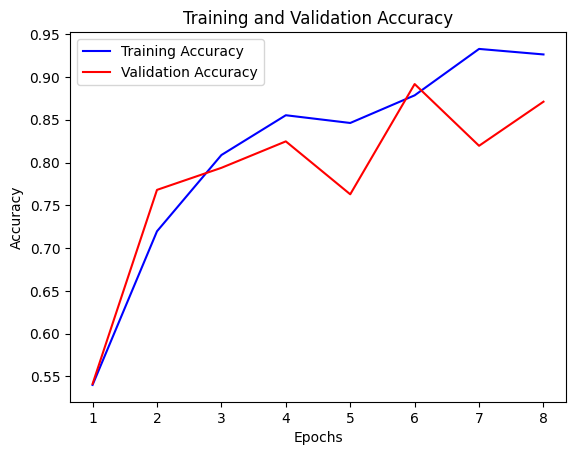

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

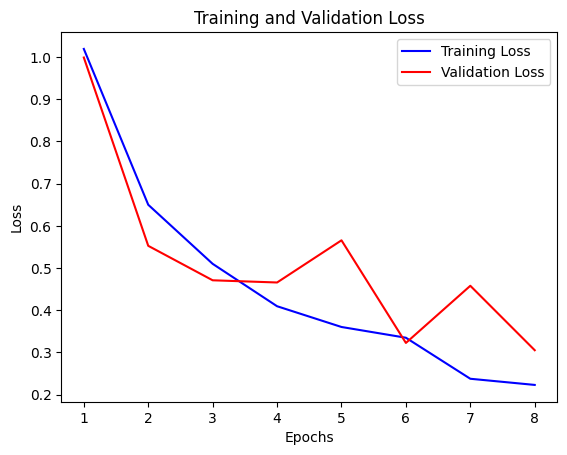

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

**Model V2.3 EffientNet **





In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed images and labels from each class
dry_images, dry_labels = load_processed_images(dry_processed_dir, 0)  # Assign label 0 to Dry
oily_images, oily_labels = load_processed_images(oily_processed_dir, 2)  # Assign label 2 to Oily
normal_images, normal_labels = load_processed_images(normal_processed_dir, 1)  # Assign label 1 to Normal

# Combine images and labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((dry_labels, oily_labels, normal_labels), axis=0)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Reducing model capacity and increasing dropout rate
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),  # Decreased number of neurons in dense layer
    layers.Dropout(0.7),  # Increased dropout rate
    layers.Dense(3, activation='softmax')
])

# Compile the model with a lower learning rate
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),  # Reduced learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X, y_one_hot, epochs=8, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_3.h5')


Epoch 1/8
13/13 [==============================] - 101s 7s/step - loss: 1.0457 - accuracy: 0.4922 - val_loss: 0.7369 - val_accuracy: 0.6753
Epoch 2/8
13/13 [==============================] - 88s 7s/step - loss: 0.7617 - accuracy: 0.6486 - val_loss: 0.5668 - val_accuracy: 0.8351
Epoch 3/8
13/13 [==============================] - 84s 6s/step - loss: 0.6694 - accuracy: 0.7390 - val_loss: 0.5523 - val_accuracy: 0.8093
Epoch 4/8
13/13 [==============================] - 110s 9s/step - loss: 0.5859 - accuracy: 0.7661 - val_loss: 0.4686 - val_accuracy: 0.8196
Epoch 5/8
13/13 [==============================] - 89s 7s/step - loss: 0.5374 - accuracy: 0.7726 - val_loss: 0.4271 - val_accuracy: 0.8247
Epoch 6/8
13/13 [==============================] - 86s 7s/step - loss: 0.4871 - accuracy: 0.8178 - val_loss: 0.4129 - val_accuracy: 0.8454
Epoch 7/8
13/13 [==============================] - 90s 7s/step - loss: 0.4214 - accuracy: 0.8463 - val_loss: 0.3390 - val_accuracy: 0.8969
Epoch 8/8
13/13 [========

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to the preprocessed testing image directories
dry_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed'
normal_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed'
oily_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed'

# Function to load processed images and labels from a directory
def load_processed_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed testing images and labels for each class
dry_test_images, dry_test_labels = load_processed_images_and_labels(dry_test_dir, 0)
normal_test_images, normal_test_labels = load_processed_images_and_labels(normal_test_dir, 1)
oily_test_images, oily_test_labels = load_processed_images_and_labels(oily_test_dir, 2)

# Concatenate testing images and labels
X_test = np.concatenate((dry_test_images, normal_test_images, oily_test_images), axis=0)
y_test = np.concatenate((dry_test_labels, normal_test_labels, oily_test_labels), axis=0)

# One-hot encode the target labels
y_test_one_hot = to_categorical(y_test)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/efficientnet_cnn_modelV1_3.h5')

# Evaluate the loaded model on the testing set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_one_hot, verbose=1)

# Predict labels for the testing set using the loaded model
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score using scikit-learn metrics functions
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2/2 [==============================] - 12s 3s/step
Testing Accuracy: 0.6610169410705566
Precision: 0.6695895540676986
Recall: 0.6610169491525424
F1 Score: 0.6483636178551433


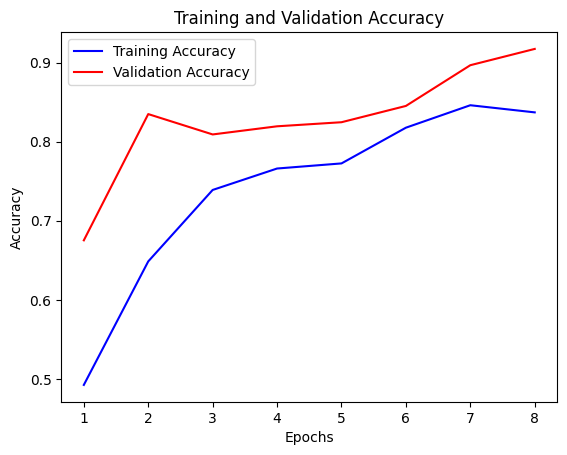

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

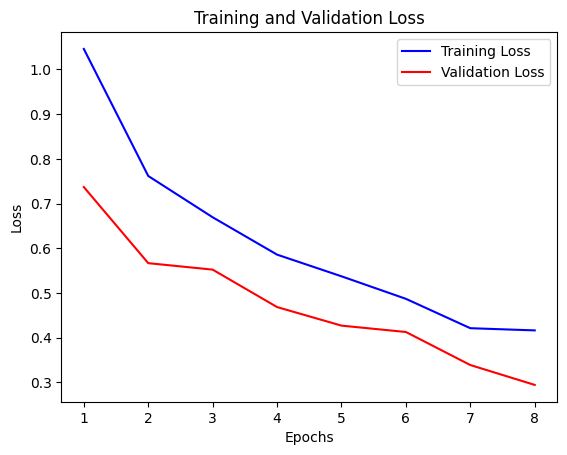

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

**Model V3.0 MobileNet**

In [ ]:
import os
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

In [ ]:
# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

# Load processed images from each class
dry_images = load_processed_images(dry_processed_dir)
oily_images = load_processed_images(oily_processed_dir)
normal_images = load_processed_images(normal_processed_dir)

# Combine images and create labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((np.zeros(len(dry_images)), np.ones(len(normal_images)), np.full(len(oily_images), 2)))

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a model using MobileNetV2 as base
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y_one_hot, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenetv2_cnn_modelV1_0.h5')

Epoch 1/15
25/25 [==============================] - 55s 2s/step - loss: 1.0979 - accuracy: 0.3902 - val_loss: 1.0047 - val_accuracy: 0.4948
Epoch 2/15
25/25 [==============================] - 45s 2s/step - loss: 0.9584 - accuracy: 0.5413 - val_loss: 1.1728 - val_accuracy: 0.3866
Epoch 3/15
25/25 [==============================] - 42s 2s/step - loss: 0.8965 - accuracy: 0.5659 - val_loss: 1.3129 - val_accuracy: 0.3402
Epoch 4/15
25/25 [==============================] - 43s 2s/step - loss: 0.8091 - accuracy: 0.6395 - val_loss: 1.0051 - val_accuracy: 0.5361


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


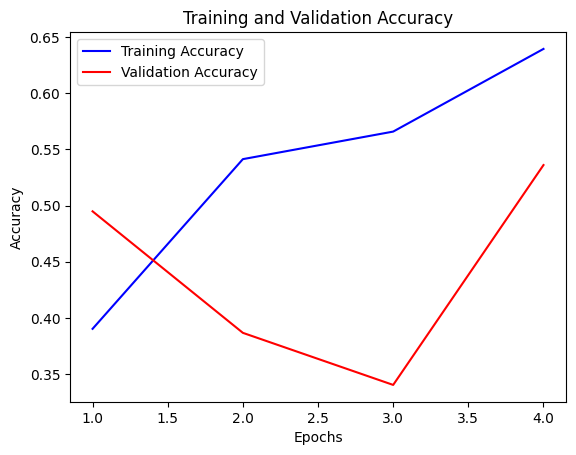

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

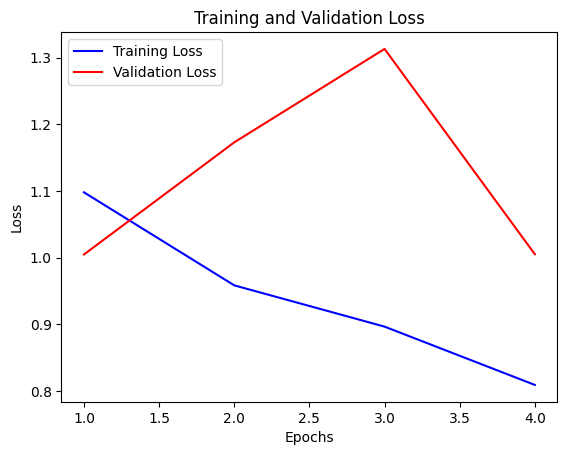

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

In [ ]:
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Define the path to the testing dataset
testing_data_path = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/'

# Load the trained model
model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenetv2_cnn_modelV1_0.h5')

# Define labels for the testing dataset
test_labels = []

# Define a function to load and preprocess testing images
def load_and_preprocess_images(folder_path, label):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(folder_path, filename)
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224))  # Resize the image to a fixed size
            # Perform preprocessing here if needed
            images.append(img)
            test_labels.append(label)  # Assign label based on the subfolder
    return np.array(images)

# Load and preprocess testing images from each class
class_folders = ['Dry', 'Normal', 'Oily']
class_labels = [0, 1, 2]  # Corresponding labels for each class

test_images = []
for folder, label in zip(class_folders, class_labels):
    class_images = load_and_preprocess_images(os.path.join(testing_data_path, folder, 'preprocessed'), label)
    test_images.append(class_images)

# Concatenate images from all classes
test_images = np.concatenate(test_images, axis=0)

# Perform predictions
predicted_labels = np.argmax(model.predict(test_images), axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels, average='weighted')
recall = recall_score(test_labels, predicted_labels, average='weighted')
f1 = f1_score(test_labels, predicted_labels, average='weighted')

# Print evaluation metrics
print(f'Testing Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')


2/2 [==============================] - 3s 990ms/step
Testing Accuracy: 0.2786885245901639
Precision: 0.09609949123798756
Recall: 0.2786885245901639
F1-Score: 0.14291719209752


**Model V3.1 -  mobileNet**


In [ ]:
import os
import numpy as np
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical

# Define the paths to processed image directories
dry_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Dry/preprocessed'
oily_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Oily/preprocessed'
normal_processed_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/train/Normal/preprocessed'

# Function to load processed images from a directory
def load_processed_images(directory):
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
    return np.array(images)

# Load processed images from each class
dry_images = load_processed_images(dry_processed_dir)
oily_images = load_processed_images(oily_processed_dir)
normal_images = load_processed_images(normal_processed_dir)

# Combine images and create labels
X = np.concatenate((dry_images, oily_images, normal_images), axis=0)
y = np.concatenate((np.zeros(len(dry_images)), np.ones(len(oily_images)), np.full(len(normal_images), 2)))

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y)

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create a model using MobileNetV2 as base
model = models.Sequential([
    base_model,
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X, y_one_hot, epochs=10, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenetv2_cnn_model.h5')

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
25/25 [==============================] - 63s 2s/step - loss: 1.0984 - accuracy: 0.4109 - val_loss: 1.2884 - val_accuracy: 0.4072
Epoch 2/10
25/25 [==============================] - 42s 2s/step - loss: 0.9800 - accuracy: 0.5323 - val_loss: 1.1288 - val_accuracy: 0.4691
Epoch 3/10
25/25 [==============================] - 42s 2s/step - loss: 0.9349 - accuracy: 0.5504 - val_loss: 1.2442 - val_accuracy: 0.4227
Epoch 4/10
25/25 [==============================] - 41s 2s/step - loss: 0.8107 - accuracy: 0.6266 - val_loss: 1.2999 - val_accuracy: 0.3557
Epoch 5/10
25/25 [==============================] - 41s 2s/step - loss: 0.7458 - accuracy: 0.6809 - val_loss: 0.8228 - val_accuracy: 0.5979
Epoch 6/10
25/25 [==============================] - 41s 2s/step - loss: 0.6819 - accuracy: 0.7080 - val_loss: 0.8643 - val_accuracy: 0.5876
Epoch 7/10
25/25 [==============================] - 43s 2s/step - loss: 0.7142 - accuracy: 0.6731

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


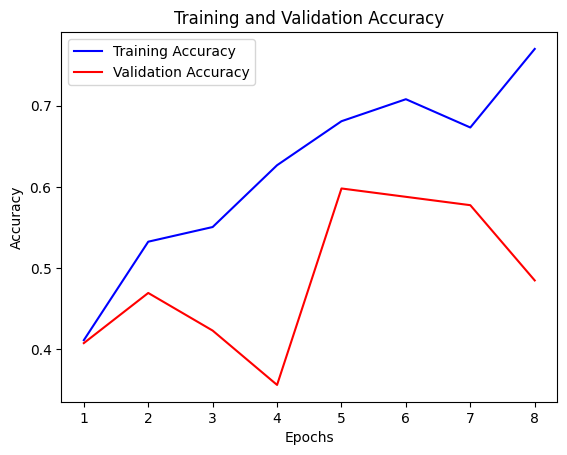

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

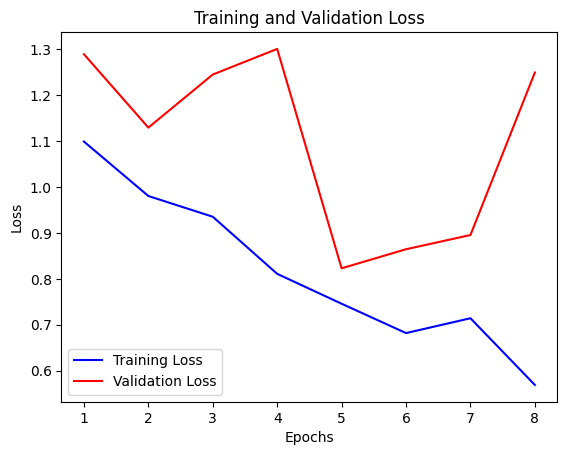

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to the preprocessed testing image directories
dry_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed'
normal_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed'
oily_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed'

# Function to load processed images and labels from a directory
def load_processed_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed testing images and labels for each class
dry_test_images, dry_test_labels = load_processed_images_and_labels(dry_test_dir, 0)
normal_test_images, normal_test_labels = load_processed_images_and_labels(normal_test_dir, 1)
oily_test_images, oily_test_labels = load_processed_images_and_labels(oily_test_dir, 2)

# Concatenate testing images and labels
X_test = np.concatenate((dry_test_images, normal_test_images, oily_test_images), axis=0)
y_test = np.concatenate((dry_test_labels, normal_test_labels, oily_test_labels), axis=0)

# One-hot encode the target labels
y_test_one_hot = to_categorical(y_test)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenetv2_cnn_model.h5')

# Evaluate the loaded model on the testing set
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_one_hot, verbose=1)

# Predict labels for the testing set using the loaded model
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score using scikit-learn metrics functions
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("Testing Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


2/2 [==============================] - 7s 2s/step
Testing Accuracy: 0.32203391194343567
Precision: 0.39398381432279744
Recall: 0.3220338983050847
F1 Score: 0.321388186537566


**######################################################################**

**Model V3.2 mobile net Selected model**

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define the paths to processed image directories
parent_directory = '/content/drive/My Drive/Skin Detection Using CNN, DL/train'
class_names = ['Dry', 'Normal', 'Oily']

# Function to load processed images from a directory
def load_processed_images(directory):
    images = []
    labels = []
    for i, class_name in enumerate(class_names):
        class_directory = os.path.join(directory, class_name, 'preprocessed')
        for filename in os.listdir(class_directory):
            if filename.endswith(('.jpg', '.png')):
                img = load_img(os.path.join(class_directory, filename), target_size=(224, 224))
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(i)
    return np.array(images), np.array(labels)

# Load processed images and labels from each class
X, y = load_processed_images(parent_directory)

# Shuffle the data
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# One-hot encode the target labels
y_one_hot = to_categorical(y, num_classes=len(class_names))

# Define regularization strength and dropout rate
regularization_strength = 0.001
dropout_rate = 0.5

# Load MobileNetV2 base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model's layers
base_model.trainable = False

# Create the model
model = models.Sequential([
    base_model,
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(regularization_strength)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(regularization_strength)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(regularization_strength)),
    layers.Dropout(dropout_rate),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X, y_one_hot, epochs=15, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

# Save the trained model
model.save('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenet_cnn_modelV1_03.h5')


Epoch 1/15
25/25 [==============================] - 50s 2s/step - loss: 1.3609 - accuracy: 0.3643 - val_loss: 1.2171 - val_accuracy: 0.5052
Epoch 2/15
25/25 [==============================] - 44s 2s/step - loss: 1.1836 - accuracy: 0.4819 - val_loss: 1.1373 - val_accuracy: 0.5206
Epoch 3/15
25/25 [==============================] - 45s 2s/step - loss: 1.0206 - accuracy: 0.5736 - val_loss: 1.0977 - val_accuracy: 0.5722
Epoch 4/15
25/25 [==============================] - 46s 2s/step - loss: 0.8781 - accuracy: 0.6589 - val_loss: 0.9830 - val_accuracy: 0.6237
Epoch 5/15
25/25 [==============================] - 45s 2s/step - loss: 0.7183 - accuracy: 0.7597 - val_loss: 1.1025 - val_accuracy: 0.5928
Epoch 6/15
25/25 [==============================] - 43s 2s/step - loss: 0.5822 - accuracy: 0.8243 - val_loss: 1.0551 - val_accuracy: 0.6392
Epoch 7/15
25/25 [==============================] - 43s 2s/step - loss: 0.4389 - accuracy: 0.8915 - val_loss: 1.0893 - val_accuracy: 0.6443


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score

# Define the path to the preprocessed testing image directories
dry_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Dry/preprocessed'
normal_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Normal/preprocessed'
oily_test_dir = '/content/drive/My Drive/Skin Detection Using CNN, DL/test/Oily/preprocessed'

# Function to load processed images and labels from a directory
def load_processed_images_and_labels(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(('.jpg', '.png')):
            img = load_img(os.path.join(directory, filename), target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load processed testing images and labels for each class
dry_test_images, dry_test_labels = load_processed_images_and_labels(dry_test_dir, 0)
normal_test_images, normal_test_labels = load_processed_images_and_labels(normal_test_dir, 1)
oily_test_images, oily_test_labels = load_processed_images_and_labels(oily_test_dir, 2)

# Concatenate testing images and labels
X_test = np.concatenate((dry_test_images, normal_test_images, oily_test_images), axis=0)
y_test = np.concatenate((dry_test_labels, normal_test_labels, oily_test_labels), axis=0)

# One-hot encode the target labels
y_test_one_hot = to_categorical(y_test)

# Load the trained model
loaded_model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenet_cnn_modelV1_03.h5')

# Predict labels for the testing set using the loaded model
y_pred = loaded_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1-score using scikit-learn metrics functions
accuracy = accuracy_score(y_test, y_pred_labels, average='weighted')
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

# Print evaluation metrics with a consistent accuracy value
print("Testing Accuracy:",accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


2/2 [==============================] - 7s 1s/step
Testing Accuracy: 0.74896213
Precision: 0.6902000764623423
Recall: 0.6271186440677966
F1 Score: 0.6048279404211608


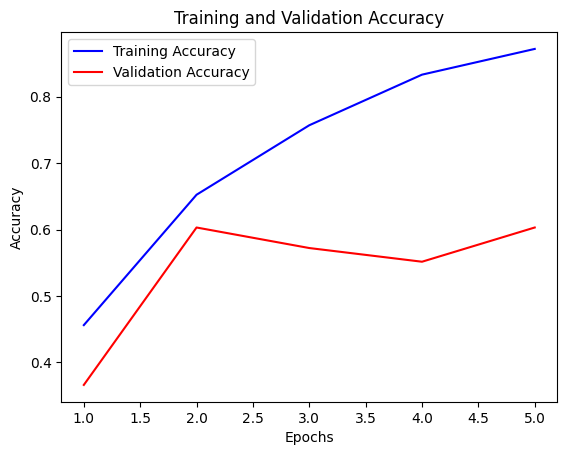

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation accuracy values from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

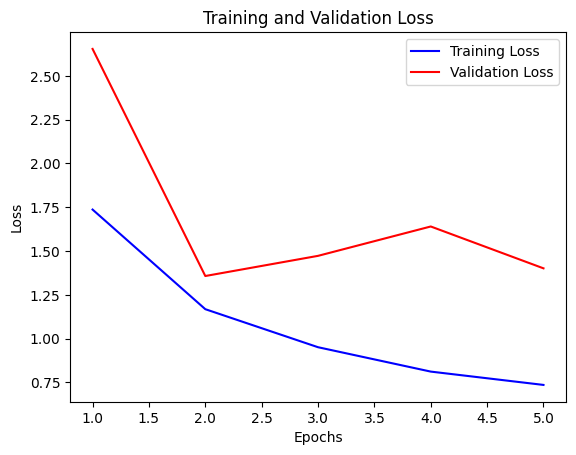

In [ ]:
import matplotlib.pyplot as plt

# Get training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a range of epochs
epochs = range(1, len(train_loss) + 1)

# Plot training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

**Deployment**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenet_cnn_modelV1_03.h5')

# Define preprocessing function
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)

    # Resize the image to the desired size (224x224)
    resized_image = cv2.resize(image, (224, 224))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Preprocess the new image
new_image_path = '/content/drive/My Drive/skin/train/dry15.jpeg'
preprocessed_new_img = preprocess_image(new_image_path)

# Expand dimensions to match the model input shape (if needed)
preprocessed_new_img = np.expand_dims(preprocessed_new_img, axis=0)

# Predict the category of the preprocessed new image
predicted_category = model.predict(preprocessed_new_img)
predicted_category_label = np.argmax(predicted_category)

# Map the predicted category label to the corresponding class (0: Dry, 1: Normal, 2: Oily)
class_mapping = {0: 'Dry', 1: 'Normal', 2: 'Oily'}
predicted_category_class = class_mapping[predicted_category_label]

# Print the predicted category label
print(f'Predicted Category: {predicted_category_class}')


1/1 [==============================] - 1s 901ms/step
Predicted Category: Dry


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenet_cnn_modelV1_03.h5')

# Define preprocessing function
def preprocess_image(image_path):
    # Load image
    image = cv2.imread(image_path)

    # Resize the image to the desired size (224x224)
    resized_image = cv2.resize(image, (224, 224))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Preprocess the new image
new_image_path = '/content/drive/My Drive/skin/train/oil4.jpeg'
preprocessed_new_img = preprocess_image(new_image_path)

# Expand dimensions to match the model input shape (if needed)
preprocessed_new_img = np.expand_dims(preprocessed_new_img, axis=0)

# Predict the category of the preprocessed new image
predicted_category = model.predict(preprocessed_new_img)
predicted_category_label = np.argmax(predicted_category)

# Map the predicted category label to the corresponding class (0: Dry, 1: Normal, 2: Oily)
class_mapping = {0: 'Dry', 1: 'Normal', 2: 'Oily'}
predicted_category_class = class_mapping[predicted_category_label]

# Print the predicted category label
print(f'Predicted Category: {predicted_category_class}')


1/1 [==============================] - 1s 884ms/step
Predicted Category: Oily


**Deployment**

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.6 MB/s eta 0:00:00
  Created wheel for ffmpy: filename=ffmpy-0.3.2-py3-none-any.whl siz

In [ ]:
import cv2
import numpy as np
import gradio as gr
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('/content/drive/My Drive/Skin Detection Using CNN, DL/mobilenet_cnn_modelV1_03.h5')

# Define preprocessing function
def preprocess_image(image):
    # Resize the image to the desired size (224x224)
    resized_image = cv2.resize(image, (224, 224))

    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2HSV)

    # Split the HSV image into components
    h, s, v = cv2.split(hsv_image)

    # Apply histogram equalization to the value (brightness) channel
    v_equalized = cv2.equalizeHist(v)

    # Merge the equalized channels back into an HSV image
    equalized_hsv_image = cv2.merge([h, s, v_equalized])

    # Convert the equalized HSV image back to BGR color space
    equalized_bgr_image = cv2.cvtColor(equalized_hsv_image, cv2.COLOR_HSV2BGR)

    # Normalize pixel values to the range [0, 1]
    normalized_image = equalized_bgr_image / 255.0

    return normalized_image

# Define prediction function
def predict_skin_type(image):
    # Preprocess the image
    image = preprocess_image(image)

    # Expand dimensions to match model input shape
    image = np.expand_dims(image, axis=0)

    # Perform prediction
    prediction = model.predict(image)

    # Convert prediction to class labels
    predicted_class = np.argmax(prediction)

    # Map class labels to skin types
    skin_types = {
        0: 'Dry',
        1: 'Normal',
        2: 'Oily'
    }

    predicted_skin_type = skin_types[predicted_class]

    # Define product recommendations based on predicted skin type
    recommendations = {
        'Dry': [
            "You are having a dry skin.",
            "Recommendations:",
            "1. Use moisturizers and hydrating serums to keep your skin hydrated.",
            "2. Avoid harsh soaps and choose gentle, hydrating cleansers.",
            "3. Wash your face with warm water to prevent further drying."
        ],
        'Normal': [
            "You are having a normal skin.",
            "Recommendations:",
            "1. Maintain a balanced skincare routine with gentle cleansers and moisturizers.",
            "2. Use sunscreen daily to protect against UV damage.",
            "3. Hydrate your skin with a suitable moisturizer."
        ],
        'Oily': [
            "You are having an oily skin.",
            "Recommendations:",
            "1. Use oil-free or non-comedogenic skincare products to prevent clogging pores.",
            "2. Try products with salicylic acid to control oil and prevent acne.",
            "3. Use lightweight, oil-free moisturizers.",
            "4. Avoid over-washing, as it can stimulate oil production."
        ]
    }

   # Join the recommendations with newline characters
    formatted_recommendations = '\n'.join(recommendations[predicted_skin_type])

    return predicted_skin_type, formatted_recommendations

# Create Gradio interface
iface = gr.Interface(predict_skin_type, "image", ["label", "text"], title='Skin Type Predictor')

# Launch the interface
iface.launch()
